# Análise da actividade parlamentar das XIV Legislatura: Dezembro de 2020

## Introdução

Introduzir cenas


## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML [DadosAbertos] são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos).

São fundamentalmente feitas as seguintes análises:

1. Vista geral das votações de cada partido, visualizado através de um _heatmap_
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)


O tratamento prévio dos dados em formato XML é feito de forma a seleccionar as votações de cada partido (ou deputado não inscrito); este processo tem alguma complexidade que se prende com o próprio processo de votação parlamentar, com múltiplas sessões e votações, pelo que foram 

De forma acessória são também feitas algumas análises adicionais, já mais removidas do objectivo central de determinação do distânciamento mas que complementam o quadro geral do que é possível.

# XIII Legislatura

### Obtenção e tratamento dos dados



In [1]:
!pip3 install --user -q itables matplotlib pandas bs4 html5lib lxml seaborn sklearn pixiedust

%matplotlib inline

from itables import show
import itables.options as opt

opt.maxColumns=100
opt.maxRows=2000
opt.lengthMenu = [10, 20, 50, 100, 200, 500]


### Obtenção do ficheiro e conversão para dataframe

In [2]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l13_ini_file = '../l13_ini.xml'
l13_ini_tree = ET.parse(l13_ini_file)
l14_ini_file = '../l14_ini.xml'
l14_ini_tree = ET.parse(l14_ini_file)


In [3]:
l13_ini_tree

In [4]:
from bs4 import BeautifulSoup
import re

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [5]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [6]:
import pandas as pd

#l13_ini_df = pd.DataFrame(l13_init_list)
#print(ini_df.shape)
l13_ini_df = ini_to_df(l13_ini_tree)
l13_ini_df.columns

Index(['id', 'Tipo', 'resultado', 'descricao', 'reuniao', 'tipoReuniao', 'PS',
       'BE', 'CDS-PP', 'PCP', 'PEV', 'PAN', 'PSD', 'data', 'unanime',
       'publicacao', 'ausencias', 'Paulo Trigo Pereira (Ninsc)', '2-PS',
       '32-PS', '10-CDS-PP', '80-PSD', '25-PS', '1-CDS-PP', '15-PCP', '2-PEV',
       '1-PAN', '43-PS', '18-BE', '8-CDS-PP', '12-PS', 'IL',
       'Cristina Rodrigues (Ninsc)', 'CH', 'Joacine Katar Moreira (Ninsc)',
       'L'],
      dtype='object')

In [7]:
l14_ini_df = ini_to_df(l14_ini_tree)
## Copy Livre voting record to new aggregate columns...
l14_ini_df["L/JKM"] = l14_ini_df["L"]
## ... and fill the NAs with JKM voting record.
l14_ini_df["L/JKM"] = l14_ini_df["L/JKM"].fillna(l14_ini_df["Joacine Katar Moreira (Ninsc)"])

#print(l14_ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]])
## Copy PAN voting record to new aggregate columns...
l14_ini_df["PAN/CR"] = l14_ini_df["PAN"]
## ... and update/replace with CR voting where it exists
l14_ini_df["PAN/CR"].update(l14_ini_df["Cristina Rodrigues (Ninsc)"])
#l14_ini_df["PAN/CR"] = l14_ini_df["PAN/CR"].fillna(l14_ini_df["Cristina Rodrigues (Ninsc)"])
#print(l14_ini_df[["id","descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]])
l14_votes = l14_ini_df.drop(["tipoReuniao"],axis=1)


In [8]:
#votes = pd.concat([ini_df.drop(["tipoReuniao"],axis=1),act_df.drop(["data","publicacao"],axis=1)], sort=True)
l13_votes = l13_ini_df.drop(["tipoReuniao"],axis=1)
#l13_votes_hm = l13_votes[['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']]
#l13_votes=l13_votes[l13_votes['unanime'] != 'unanime']

l13_votes_hm = l13_votes[['BE', 'PCP', 'PEV', 'PS', 'PAN','PSD','CDS-PP']]


## Mapa térmico

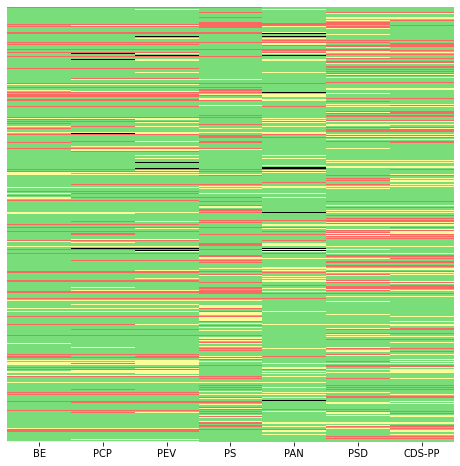

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

l13_votes_hmn = l13_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)

voting_palette = ["#FB6962","#FCFC99","#79DE79", "black"]

fig = plt.figure(figsize=(8,8))
sns.heatmap(l13_votes_hmn,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
           )
plt.show()

## Quem vota com quem

Com estes dados podemos tentar obter uma resposta mais clara do que o "mapa térmico" anterior nos apresenta como sendo semelhanças e diferenças no registo de votação.

Uma das questões que se coloca (e normalmente coloca-se com maior ênfase sempre que há uma votação que é apontada como sendo "atípica", com base na percepção geral do que é o comportamente de voto habitual de cada partido) é saber "quem vota com quem". Estes dados podem ser obtidos através da identificação, para cada partido, da quantidade de votações onde cada outro votou da mesma forma e criação de uma tabela com os resultados:

In [10]:
import numpy as np
pv_list = []
print("Total voting instances: ", l13_votes_hm.shape[0])

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in l13_votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in l13_votes_hmn:
        pv_dict[column]=l13_votes_hmn[l13_votes_hmn[party] == l13_votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

l13_pv = pd.DataFrame(pv_list,index=l13_votes_hm.columns)
l13_pv

Total voting instances:  6400


BE   PCP   PEV    PS   PAN   PSD  CDS-PP
BE      6400  5665  5561  4184  4645  3228    3358
PCP     5665  6400  5843  4166  4363  3269    3357
PEV     5561  5843  6400  3871  4806  2992    3067
PS      4184  4166  3871  6400  3648  3642    3525
PAN     4645  4363  4806  3648  6400  3308    3427
PSD     3228  3269  2992  3642  3308  6400    5307
CDS-PP  3358  3357  3067  3525  3427  5307    6400

In [11]:
l13_votes

id Tipo resultado                                          descricao  \
0     73609    I  Aprovado  Texto Final apresentado pela Comissão de Orçam...   
1     73731    I  Aprovado                                                NaN   
2     73608    I  Aprovado  Texto Final apresentado pela Comissão de Orçam...   
3     73730    I  Aprovado                                                NaN   
4     71310    I  Aprovado  Texto Final apresentado pela Comissão de Traba...   
...     ...  ...       ...                                                ...   
6395  81479    I  Aprovado                                                NaN   
6396  81478    I  Aprovado                                                NaN   
6397  82064    I  Aprovado                                                NaN   
6398  81636    I  Aprovado                                                NaN   
6399  81477    I  Aprovado                                                NaN   

     reuniao       PS         BE     CDS-PP        PCP        PEV  ... 1-PAN  \
0         16  A Favor    A Favor    A Favor    A Favor    A Favor  ...   NaN   
1         75  A Favor    A Favor    A Favor    A Favor        NaN  ...   NaN   
2         16  A Favor    A Favor    A Favor    A Favor    A Favor  ...   NaN   
3         75  A Favor    A Favor    A Favor    A Favor        NaN  ...   NaN   
4         29  A Favor    A Favor  Abstenção    A Favor    A Favor  ...   NaN   
...      ...      ...        ...        ...        ...        ...  ...   ...   
6395      27  A Favor  Abstenção    A Favor  Abstenção  Abstenção  ...   NaN   
6396      27  A Favor  Abstenção    A Favor  Abstenção  Abstenção  ...   NaN   
6397      47  A Favor    A Favor    A Favor    A Favor    A Favor  ...   NaN   
6398      33  A Favor    A Favor    A Favor    A Favor    A Favor  ...   NaN   
6399      27  A Favor    A Favor    A Favor    A Favor    A Favor  ...   NaN   

     43-PS 18-BE 8-CDS-PP  12-PS   IL Cristina Rodrigues (Ninsc)   CH  \
0      NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
1      NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
2      NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
3      NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
4      NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
...    ...   ...      ...    ...  ...                        ...  ...   
6395   NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
6396   NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
6397   NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
6398   NaN   NaN      NaN    NaN  NaN                        NaN  NaN   
6399   NaN   NaN      NaN    NaN  NaN                        NaN  NaN   

     Joacine Katar Moreira (Ninsc)    L  
0                              NaN  NaN  
1                              NaN  NaN  
2                              NaN  NaN  
3                              NaN  NaN  
4                              NaN  NaN  
...                            ...  ...  
6395                           NaN  NaN  
6396                           NaN  NaN  
6397                           NaN  NaN  
6398                           NaN  NaN  
6399                           NaN  NaN  

[6400 rows x 35 columns]

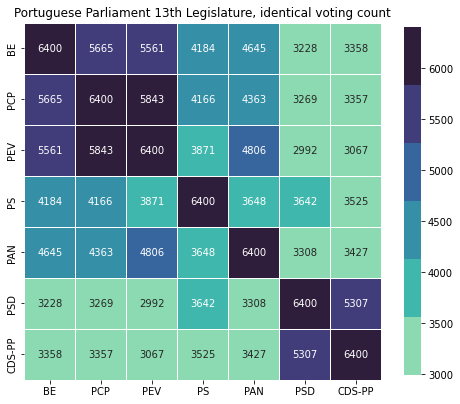

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    l13_pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 13th Legislature, identical voting count')

plt.show()

In [13]:
def identical_vote_matrix(vdf,plist):
    pv_list = []
    vdf=vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)
    for party in vdf.columns:
        pv_dict = collections.OrderedDict()
        for column in vdf:
            pv_dict[column]=vdf[vdf[party] == vdf[column]].shape[0]
        pv_list.append(pv_dict)

    return pd.DataFrame(pv_list,index=vdf.columns)

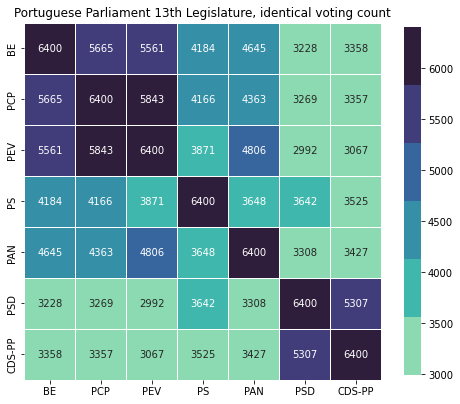

In [14]:
parties=['BE', 'PCP', 'PEV', 'PS', 'PAN','PSD','CDS-PP']
l14_parties=['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    identical_vote_matrix(l13_votes, parties),
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 13th Legislature, identical voting count')

plt.show()

## Matriz de distância

Com base nos histórico de votações de cada partido produzimos uma matriz de distâncias entre eles; uma matriz de distâncias é uma matriz quadradra $n\times n$ (onde _n_ é o número de partidos) e onde a distância entre _p_ e _q_ é o valor de $ d_{pq} $.

$ 
\begin{equation}
D= \begin{bmatrix} d_{11} & d_{12} & \cdots & d_{1 n} \\  d_{21} & d_{22} & \cdots & d_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ d_{31} & d_{32} & \cdots & d_{n n}   \end{bmatrix}_{\ n\times n}  
\end{equation}
$


A distância é obtida através da comparação de todas as observações de cada par usando uma determinada métrica de distância, sendo a distância euclideana bastante comum em termos gerais e também dentro de estudos sobre o mesmo domínio temático _(Krilavičius and Žilinskas 2008)_: cada elemento da matriz representa $ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$, equivalente, para dois pontos $P,Q $ , à mais genérica distância de Minkowski   $ D\left(P,Q\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{\frac {1}{p}} $ para $ p = 1$, mas note-se que a diagonal da matrix irá representar a distância entre um partido e ele próprio, logo $ d_{11} = d_{22} = \dots = d_{nn} = 0 $.

Na secção  [Distâncias e matrizes](Distâncias_e_matrizes) colocámos uma discussão mais detalhada (mas passo-a-passo e destinada a quem não tenha necessariamente presente a matemática utilizada) sobre distâncias, _clustering_ e como são calculdadas, para quem tenha interesse numa compreensão mais quantitativa da matéria.

A conversão de votos em representações númericas pode ser feita de várias formas _(Hix, Noury, and Roland 2006)_; adoptamos a abordagem de Krilavičius & Žilinskas (2008) no já citado  trabalho relativo às votações no parlamento lituano por nos parecer apropriada à realidade portuguesa:

* A favor: 1
* Contra: -1
* Abstenção: 0
* Ausência: 0

Este ponto é (mais um) dos que de forma relativamente opaca - pois raramente os detalhes têm a mesma projecção que os resultado finais - podem influenciar os resultados; cremos que em particular a equiparação entre _abstenção_ e _ausência_ merece alguma reflexão: considerámos que uma ausência em determinada votação tem um peso equivalente à abstenção, embora uma de forma passiva e outra activa.

Para obtermos a matriz de distância usamos a função `pdist` e construímos um _dataframe_ que é uma matriz simétrica das distâncias entre os partidos.

In [15]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show

l13_votes_hmn = l13_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
l13_votes_t = l13_votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
l13_pwdist = pdist(l13_votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
l13_distmat = pd.DataFrame(
    squareform(l13_pwdist), # pass a symmetric distance matrix
    columns = l13_votes_t.index,
    index = l13_votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
l13_distmat

BE        PCP        PEV         PS        PAN        PSD  \
BE       0.000000  38.678159  35.665109  77.775317  54.240206  92.585096   
PCP     38.678159   0.000000  28.035692  76.791927  61.449166  91.411159   
PEV     35.665109  28.035692   0.000000  79.177017  54.644304  93.284511   
PS      77.775317  76.791927  79.177017   0.000000  77.967942  81.135689   
PAN     54.240206  61.449166  54.644304  77.967942   0.000000  81.510735   
PSD     92.585096  91.411159  93.284511  81.135689  81.510735   0.000000   
CDS-PP  91.027468  90.288427  92.714616  83.898749  80.523289  43.451122   

           CDS-PP  
BE      91.027468  
PCP     90.288427  
PEV     92.714616  
PS      83.898749  
PAN     80.523289  
PSD     43.451122  
CDS-PP   0.000000

In [16]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show
from scipy.cluster.hierarchy import dendrogram

def political_distance_matrix(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')

    ## Create a square dataframe with the pairwise distances: the distance matrix
    distmat = pd.DataFrame(
        squareform(pwdist), # pass a symmetric distance matrix
        columns = vdf_votes_t.index,
        index = vdf_votes_t.index
    )
    return distmat
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

def political_pwdist(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')
    return pwdist
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
    
def political_distance_clustermap(vdf, plist, subtitle):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Perform hierarchical linkage on the distance matrix using Ward's method.
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )
    sns.clustermap(
        distmat,
        annot = True,
        cmap=sns.color_palette("Reds_r"),
        linewidth=1,
        #standard_scale=1,
        row_linkage=distmat_link,
        col_linkage=distmat_link,
        #fmt=".0%",
        figsize=(7,7)).fig.suptitle(subtitle)
    plt.show()

def political_linkage(vdf,plist):
    vdf = vdf[plist]
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True)
    return distmat_link

def political_dendogram(vdf, plist, subtitle):
    vdf = vdf[plist]

    fig = plt.figure(figsize=(8,5))
    dendrogram(political_linkage(vdf,plist), labels=vdf.columns)
    plt.title(subtitle)
    plt.show()

In [17]:
political_distance_matrix(l13_votes, parties)

BE        PCP        PEV         PS        PAN        PSD  \
BE       0.000000  38.678159  35.665109  77.775317  54.240206  92.585096   
PCP     38.678159   0.000000  28.035692  76.791927  61.449166  91.411159   
PEV     35.665109  28.035692   0.000000  79.177017  54.644304  93.284511   
PS      77.775317  76.791927  79.177017   0.000000  77.967942  81.135689   
PAN     54.240206  61.449166  54.644304  77.967942   0.000000  81.510735   
PSD     92.585096  91.411159  93.284511  81.135689  81.510735   0.000000   
CDS-PP  91.027468  90.288427  92.714616  83.898749  80.523289  43.451122   

           CDS-PP  
BE      91.027468  
PCP     90.288427  
PEV     92.714616  
PS      83.898749  
PAN     80.523289  
PSD     43.451122  
CDS-PP   0.000000

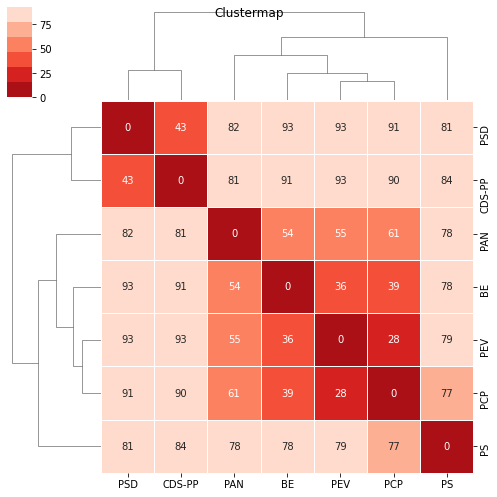

In [18]:
political_distance_clustermap(l13_votes, parties,"Clustermap")

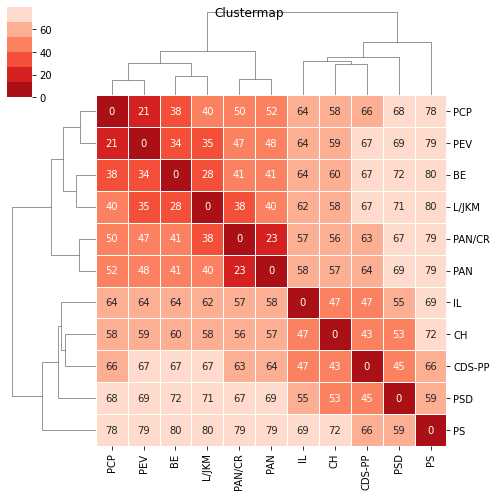

In [19]:
political_distance_clustermap(l14_votes, l14_parties,"Clustermap")

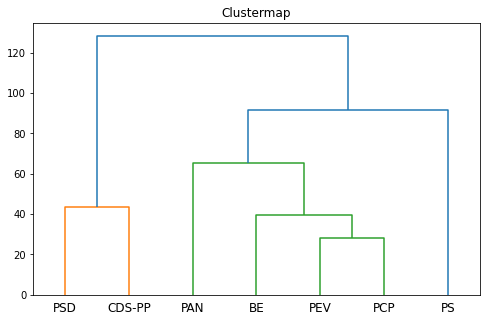

In [20]:
political_dendogram(l13_votes, parties,"Clustermap")

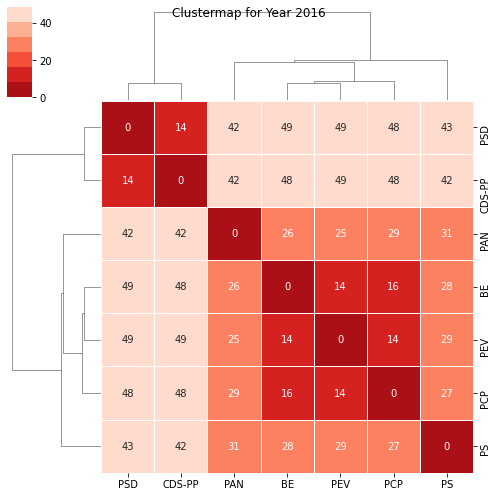

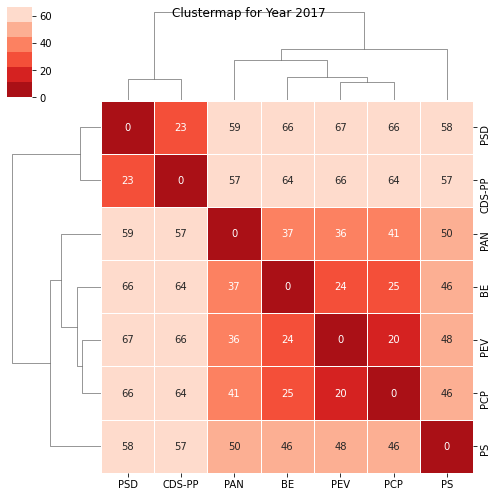

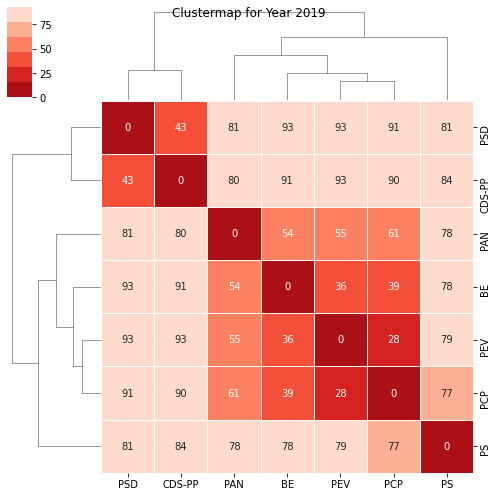

In [21]:
#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

for year in [2015,2016,2017,2018,2019]:
    y_votes=l13_votes[(l13_votes['data'] > '{}-01-01'.format(2015)) & (l13_votes['data'] < '{}-01-01'.format(year+1))]
    political_distance_clustermap(y_votes, parties,"Clustermap for Year {}".format(year))


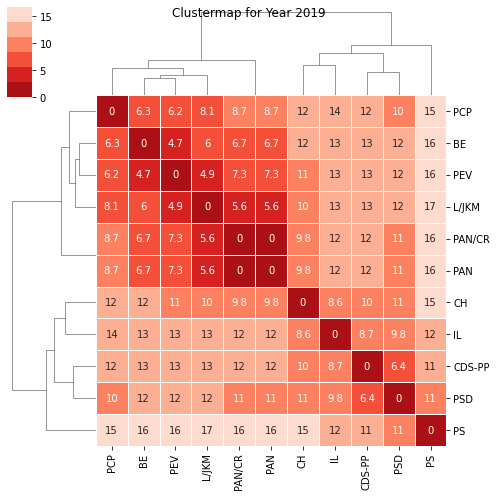

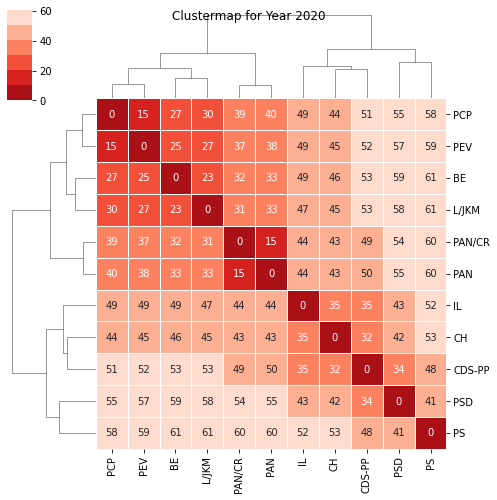

In [22]:
#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

for year in [2019, 2020, 2021]:
    y_votes=l14_votes[(l14_votes['data'] > '{}-01-01'.format(year)) & (l14_votes['data'] < '{}-01-01'.format(year+1))]
    political_distance_clustermap(y_votes, l14_parties,"Clustermap for Year {}".format(year))


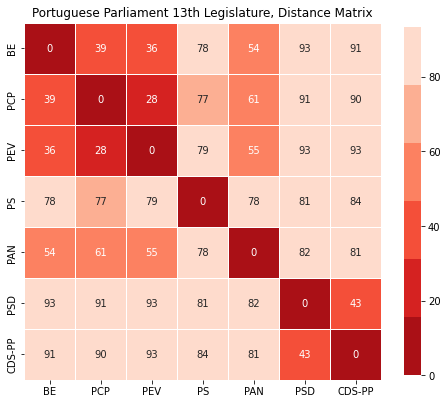

In [23]:
## Display the heatmap of the distance matrix

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    l13_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 13th Legislature, Distance Matrix')

plt.show()

In [24]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
l13_distmat_link = hc.linkage(l13_pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    l13_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=l13_distmat_link,
    col_linkage=l13_distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 13th Legislature, Clustermap')

plt.show()

In [25]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(8,5))
dendrogram(l13_distmat_link, labels=l13_votes_hmn.columns)

plt.title("Portuguese Parliament 14th Legislature, Dendogram")
plt.show()

## _Clustering_ de observações: DBSCAN e _Spectrum Scaling_


In [26]:
import numpy as np

l13_distmat_mm=((l13_distmat-l13_distmat.min().min())/(l13_distmat.max().max()-l13_distmat.min().min()))*1
pd.DataFrame(l13_distmat_mm, l13_distmat.index, l13_distmat.columns)

BE       PCP       PEV        PS       PAN       PSD    CDS-PP
BE      0.000000  0.414626  0.382326  0.833743  0.581449  0.992502  0.975805
PCP     0.414626  0.000000  0.300540  0.823201  0.658728  0.979918  0.967882
PEV     0.382326  0.300540  0.000000  0.848769  0.585781  1.000000  0.993891
PS      0.833743  0.823201  0.848769  0.000000  0.835808  0.869766  0.899386
PAN     0.581449  0.658728  0.585781  0.835808  0.000000  0.873786  0.863201
PSD     0.992502  0.979918  1.000000  0.869766  0.873786  0.000000  0.465791
CDS-PP  0.975805  0.967882  0.993891  0.899386  0.863201  0.465791  0.000000

In [27]:
l13_affinmat_mm = pd.DataFrame(1-l13_distmat_mm, l13_distmat.index, l13_distmat.columns)
l13_affinmat_mm 

BE       PCP       PEV        PS       PAN       PSD    CDS-PP
BE      1.000000  0.585374  0.617674  0.166257  0.418551  0.007498  0.024195
PCP     0.585374  1.000000  0.699460  0.176799  0.341272  0.020082  0.032118
PEV     0.617674  0.699460  1.000000  0.151231  0.414219  0.000000  0.006109
PS      0.166257  0.176799  0.151231  1.000000  0.164192  0.130234  0.100614
PAN     0.418551  0.341272  0.414219  0.164192  1.000000  0.126214  0.136799
PSD     0.007498  0.020082  0.000000  0.130234  0.126214  1.000000  0.534209
CDS-PP  0.024195  0.032118  0.006109  0.100614  0.136799  0.534209  1.000000

In [28]:
sns.set(style="white")

## Make the top triangle
mask = np.triu(np.ones_like(l13_affinmat_mm, dtype=bool))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.title('Portuguese Parliament 13th Legislature, Affinity Matrix')

## Display the heatmap of the affinity matrix, masking the top triangle

sns.heatmap(
    l13_affinmat_mm,
    cmap=sns.color_palette("Greens"),
    linewidth=1,
    annot = False,
    square =True,
    cbar_kws={"shrink": .8},
    mask=mask,linewidths=.5)

plt.show()

In [29]:
from sklearn.cluster import DBSCAN

dbscan_labels = DBSCAN(eps=1.3).fit(l13_affinmat_mm)
dbscan_labels.labels_
dbscan_dict = dict(zip(l13_distmat_mm,dbscan_labels.labels_))
dbscan_dict

{'BE': 0, 'PCP': 0, 'PEV': 0, 'PS': 0, 'PAN': 0, 'PSD': -1, 'CDS-PP': -1}

In [30]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(l13_affinmat_mm)
sc_dict = dict(zip(l13_distmat,sc))

print(sc_dict)

{'BE': 0, 'PCP': 0, 'PEV': 0, 'PS': 2, 'PAN': 0, 'PSD': 1, 'CDS-PP': 1}


### _Multidimensional scaling_ 

Até agora temos conseguido extrair informação interessante dos dados de votação:

1. O mapa térmico de votação permite-nos uma primeira visão do comportamente de todos os partidos. 
2. A matriz de distâncias fornece-nos uma forma de comparar as distâncias entre os diferentes partidos através de um mapa térmico.
3. O dendograma identifica de forma hierárquica agrupamentos.
4. Através de DBSCAN e _Spectrum Clustering_ identificamos "blocos" com base na matriz de afinidade.

Não temos ainda uma forma de visualizar a distância relativa de cada partido em relação aos outros com base nas distâncias/semelhanças: temos algo próximo com base no dendograma mas existem outras formas de visualização interessantes.

Uma das formas é o _multidimensional scaling_ que permite visualizar a distância ao projectar em 2 ou 3 dimensões (também conhecidas como _dimensões visualizavies_) conjuntos multidimensionais, mantendo a distância relativa _(“Graphical Representation of Proximity Measures for Multidimensional Data « The Mathematica Journal” 2020)_.

Como é habitual temos em Python, através da biblioteca `scikit-learn` (que já usámos para DBSCAN e _Spectrum Clustering_), uma implementação que podemos usar sem grande dificuldade _(“2.2. Manifold Learning — Scikit-Learn 0.23.2 Documentation” 2020)_.

In [31]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(l13_distmat_mm.values)
coords = results.embedding_
coords

array([[ 0.43983863, -0.07540615],
       [ 0.20948768, -0.37249238],
       [ 0.35465672, -0.27623978],
       [-0.42670011, -0.38803937],
       [ 0.30771037,  0.295206  ],
       [-0.55593858,  0.28287925],
       [-0.32905472,  0.53409242]])

In [32]:
## Graphic options
sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))

plt.title('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)

for label, x, y in zip(l13_distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))
plt.show()

In [33]:
import plotly.express as px
from sklearn.decomposition import PCA

df = px.data.iris()
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df['species'])
fig.show()

In [34]:
fig = px.scatter(coords)
fig.show()

In [35]:
l13_distmat_mm

BE       PCP       PEV        PS       PAN       PSD    CDS-PP
BE      0.000000  0.414626  0.382326  0.833743  0.581449  0.992502  0.975805
PCP     0.414626  0.000000  0.300540  0.823201  0.658728  0.979918  0.967882
PEV     0.382326  0.300540  0.000000  0.848769  0.585781  1.000000  0.993891
PS      0.833743  0.823201  0.848769  0.000000  0.835808  0.869766  0.899386
PAN     0.581449  0.658728  0.585781  0.835808  0.000000  0.873786  0.863201
PSD     0.992502  0.979918  1.000000  0.869766  0.873786  0.000000  0.465791
CDS-PP  0.975805  0.967882  0.993891  0.899386  0.863201  0.465791  0.000000

In [36]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with DBSCAN clusters (2D)')

for label, x, y in zip(l13_distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(1+dbscan_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

In [37]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(l13_distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

/tmp/ipykernel_10175/2731638141.py:15: MatplotlibDeprecationWarning:


The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.



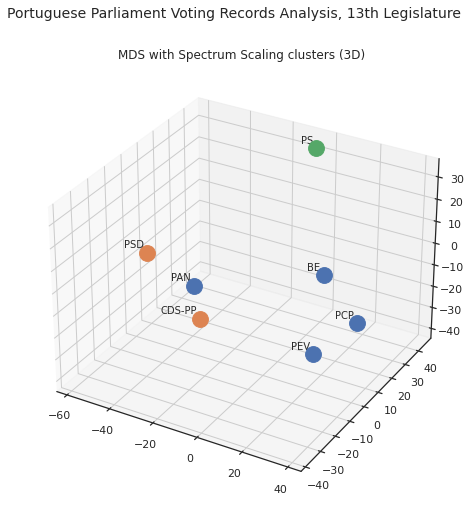

In [38]:
## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random

mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(l13_distmat.values)
parties = l13_distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()


In [39]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [67]:
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y in zip(l13_distmat_mm.columns, coords[:, 0], coords[:, 1]):
#for i in parties:
    fig.add_trace(go.Scatter(x=[x], y=[y],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 600,
    height = 600,
    title = "fixed-ratio axes",
    template="plotly_white",
    showlegend=False,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
            
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

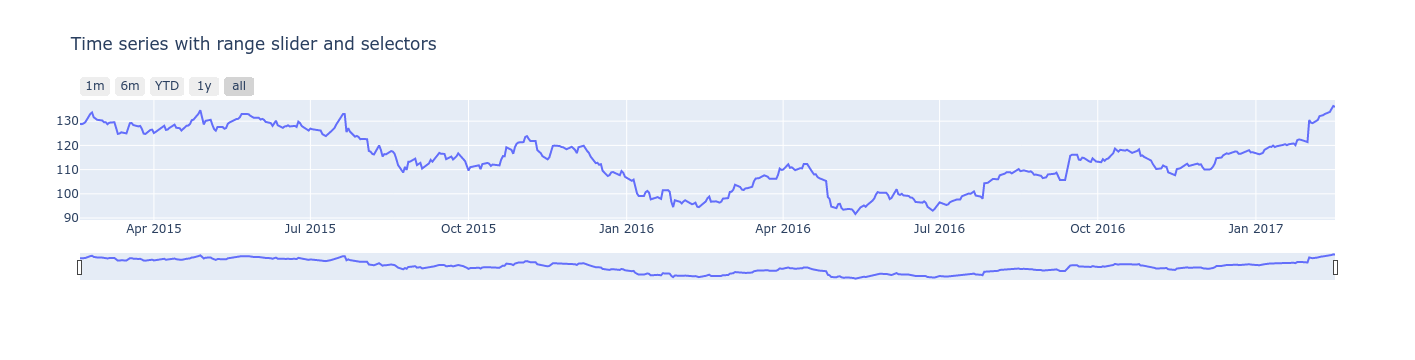

In [68]:
import plotly.graph_objects as go

import pandas as pd

# Load data
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")
df.columns = [col.replace("AAPL.", "") for col in df.columns]

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.Date), y=list(df.High)))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [71]:
years = ["2015", "1962", "1967", "1972", "1977", "1982", "1987", "1992", "1997", "2002",
         "2007"]

Date        Open        High         Low       Close    Volume  \
0    2015-02-17  127.489998  128.880005  126.919998  127.830002  63152400   
1    2015-02-18  127.629997  128.779999  127.449997  128.720001  44891700   
2    2015-02-19  128.479996  129.029999  128.330002  128.449997  37362400   
3    2015-02-20  128.619995  129.500000  128.050003  129.500000  48948400   
4    2015-02-23  130.020004  133.000000  129.660004  133.000000  70974100   
..          ...         ...         ...         ...         ...       ...   
501  2017-02-10  132.460007  132.940002  132.050003  132.119995  20065500   
502  2017-02-13  133.080002  133.820007  132.750000  133.289993  23035400   
503  2017-02-14  133.470001  135.089996  133.250000  135.020004  32815500   
504  2017-02-15  135.520004  136.270004  134.619995  135.509995  35501600   
505  2017-02-16  135.669998  135.899994  134.839996  135.350006  22118000   

       Adjusted          dn        mavg          up   direction  
0    122.905254  106.741052  117.927667  129.114281  Increasing  
1    123.760965  107.842423  118.940333  130.038244  Increasing  
2    123.501363  108.894245  119.889167  130.884089  Decreasing  
3    124.510914  109.785449  120.763500  131.741551  Increasing  
4    127.876074  110.372516  121.720167  133.067817  Increasing  
..          ...         ...         ...         ...         ...  
501  132.119995  114.494004  124.498666  134.503328  Decreasing  
502  133.289993  114.820798  125.205166  135.589534  Increasing  
503  135.020004  115.175718  125.953499  136.731280  Increasing  
504  135.509995  115.545035  126.723499  137.901963  Decreasing  
505  135.350006  116.203299  127.504333  138.805366  Decreasing  

[506 rows x 11 columns]

In [66]:
for n in range(0, 500, 10):
    print(n)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [65]:
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 1000,
    height = 1000,
    title = "fixed-ratio axes",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [48]:
for label, x, y in zip(l13_distmat_mm.columns, coords[:, 0], coords[:, 1]):
    print(label,x,y)

BE 34.52729382189842 -12.45509184424632
PCP 38.66455163180769 4.7868930394066025
PEV 34.87641558422778 -19.033227296775983
PS -5.428014808905394 43.743860893407444
PAN -4.713648377793149 -36.92324289905651
PSD -57.8514014513174 4.970380352151857
CDS-PP -40.075196399917935 14.910427755112906


In [41]:
for i in parties:
    print(i)


BE
PCP
PEV
PS
PAN
PSD
CDS-PP
